In [1]:
!pip install pandoc

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import biosppy.signals.ecg as ecg
from scipy.signal import find_peaks
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.backend import clear_session

c:\Users\raafa\anaconda3\envs\DQConda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\raafa\anaconda3\envs\DQConda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\raafa\anaconda3\envs\DQConda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\raafa\anaconda3\envs\DQConda\lib\site-packages\tensorflow\

In [3]:
#file names
mitbih_train = 'mitbih_train'
mitbih_test = 'mitbih_test'
abnormal = 'ptbdb_abnormal'
normal = 'ptbdb_normal'

In [4]:
train_data = pd.read_csv(f"../archive/{mitbih_train}.csv", header=None)
test_data = pd.read_csv(f"../archive/{mitbih_test}.csv", header=None)
normal = pd.read_csv(f"../archive/{normal}.csv", header=None)
abnormal = pd.read_csv(f"../archive/{abnormal}.csv", header=None)

In [5]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


In [7]:
train_data.shape

(87554, 188)

# Exploratory Data Analysis

## Arrhythmia Dataset

In [8]:

def make_plot(data, dataset_name, index):
    cols = 3
    rows = int([(index//3+1) if index%3>0 else index/3].pop())
    entry = 0
    fig, axs = plt.subplots(rows, cols, figsize=(8, 6))
    for row in range(rows):
        for col in range(cols):
            axs[row,col].plot(data.loc[entry, :], label=f"{dataset_name} ECG Index: {row}")
            axs[row, col].set_title(f"{dataset_name}")# ECG Index: {entry}")
            if entry < index:
                entry +=1
            else:
                break
    #axs[row, col].title(f"{dataset_name} ECG Index: {row}")
    #plt.plot(data.loc[index,:])
    plt.tight_layout()
    plt.show()

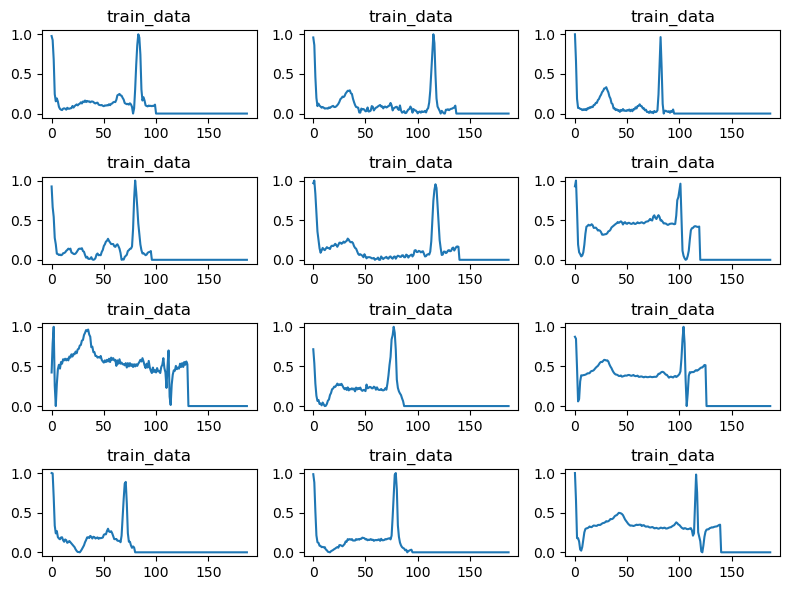

In [9]:
make_plot(train_data, 'train_data', 11)

Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

In [10]:
value_counts = train_data.iloc[:,-1].value_counts()
value_counts

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

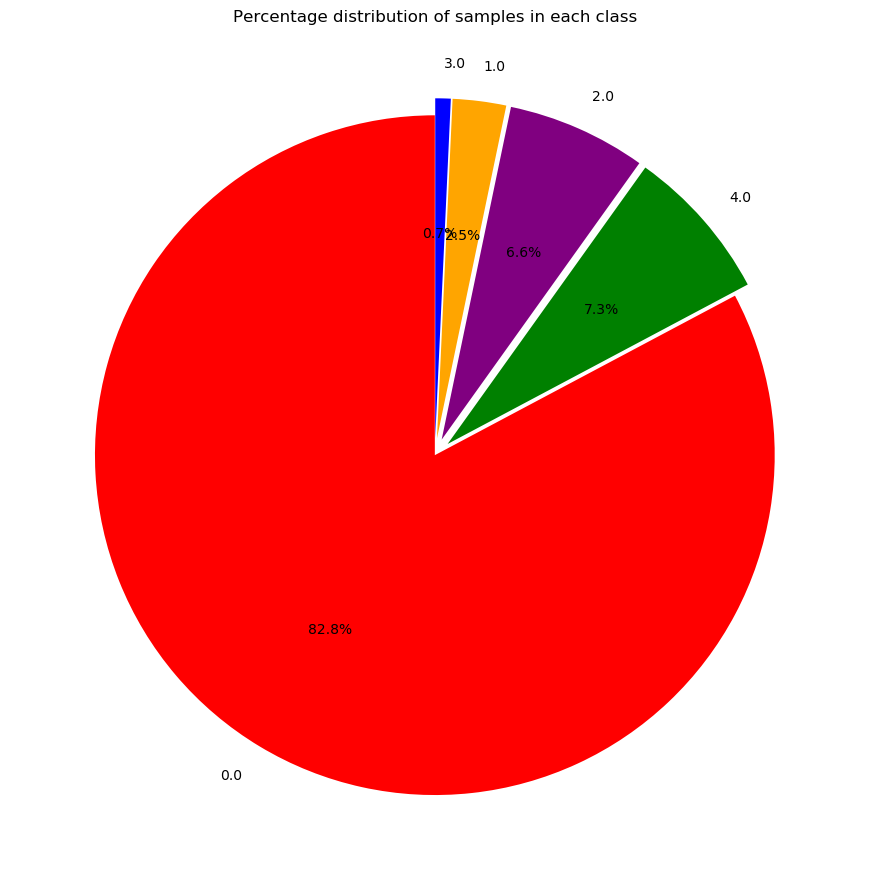

In [11]:
plt.figure(figsize=(16,9))
explode = (0, 0.05, 0.05, 0.05, 0.05)
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=['red', 'green', 'purple', 'orange', 'blue'], startangle=90, explode=explode)
plt.title('Percentage distribution of samples in each class')
plt.tight_layout()
plt.show()

<Figure size 1600x900 with 0 Axes>

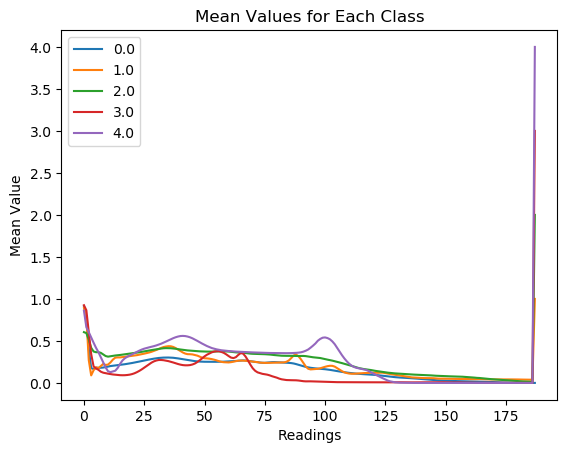

In [12]:
class_means = train_data.groupby(train_data.iloc[:, -1]).mean()

plt.figure(figsize=(16,9))
class_means.T.plot(kind='line') 
plt.xlabel('Readings')
plt.ylabel('Mean Value')
plt.title('Mean Values for Each Class')
plt.legend()
plt.show()

## Removing Noise

In [13]:
def preprocess(dataset):
    dataset = dataset.values
    if dataset.ndim == 2:
        dataset = dataset.ravel()
    window_size = 5
    filtered_data = np.convolve(dataset, np.ones(window_size)/window_size, mode='same')
    return filtered_data

In [14]:
train_filtered = pd.DataFrame()
for row in range(len(train_data)):
    train_filtered[row]  = preprocess(train_data.iloc[row,:])

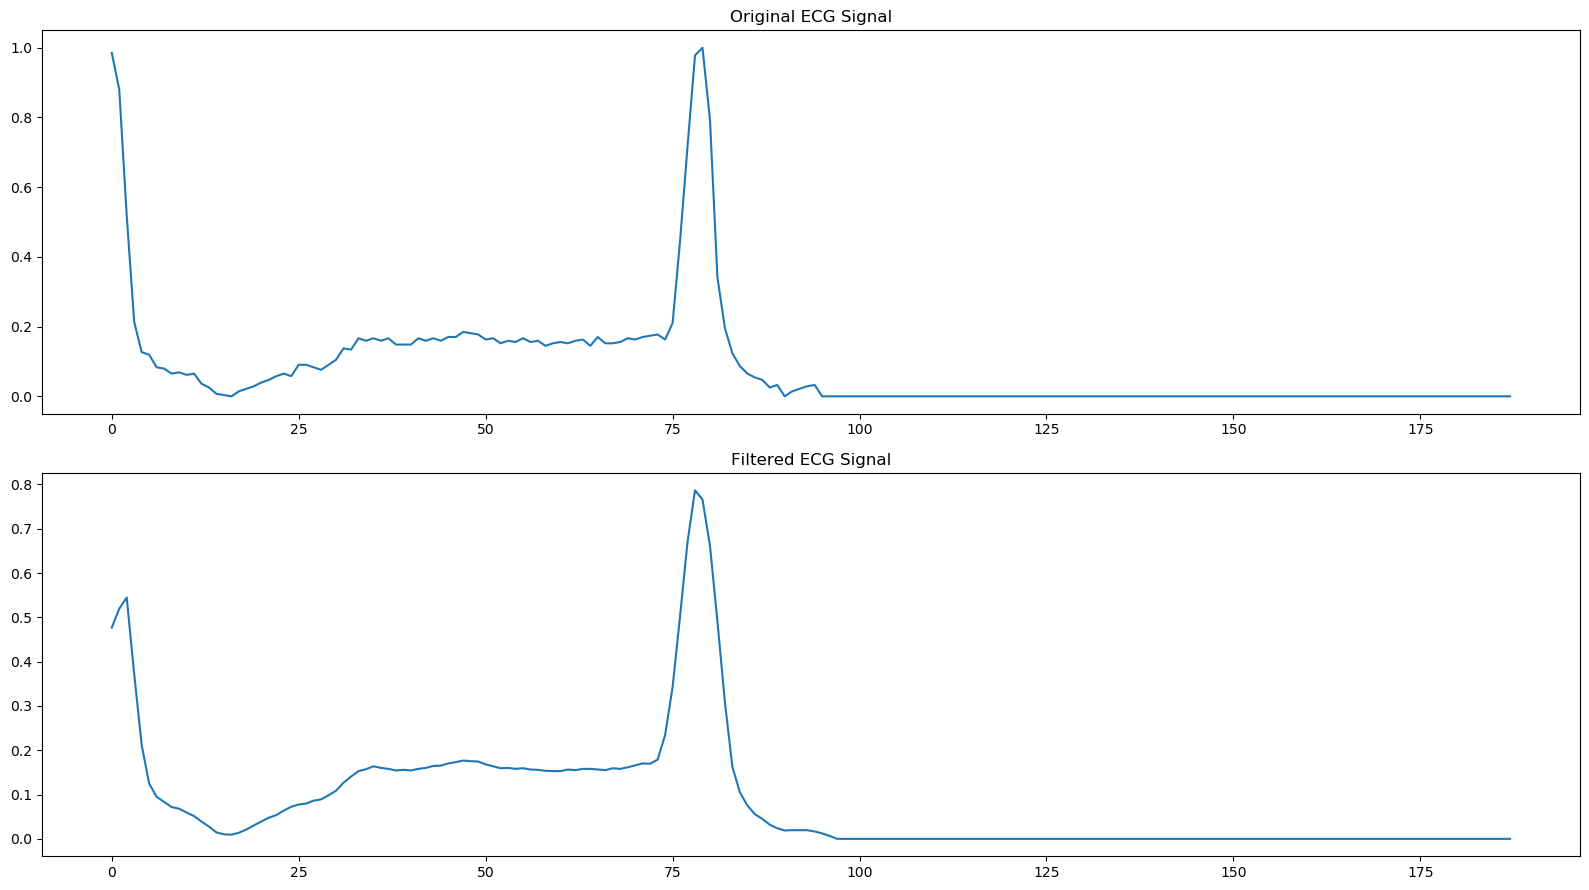

In [15]:
#plotting the results
plt.figure(figsize=(16,9))
plt.subplot(2, 1, 1)
#train_data[0].plot(kind='line')
plt.plot(train_data.iloc[10,:])
plt.title("Original ECG Signal")
plt.subplot(2, 1, 2)
plt.plot(train_filtered[10])
plt.title("Filtered ECG Signal")
plt.tight_layout()
plt.show()

## R-Peak

### Detecting R-Peak values

In [16]:
def detect_r_peak(filtered_data):
        dataset = filtered_data.values
        if dataset.ndim == 2:
                dataset = dataset.ravel()
        rpeak_indices, _ = find_peaks(dataset, height=0.6, distance=200)
        return rpeak_indices, _

def make_rpeak_plot(dataset, rpeak):
        plt.figure(figsize=(16,9))
        plt.plot(dataset)
        plt.plot(rpeak, dataset[rpeak], 'ro', label='R-Peaks')
        plt.title("Filtered ECG Signal")
        plt.tight_layout()
        plt.show()

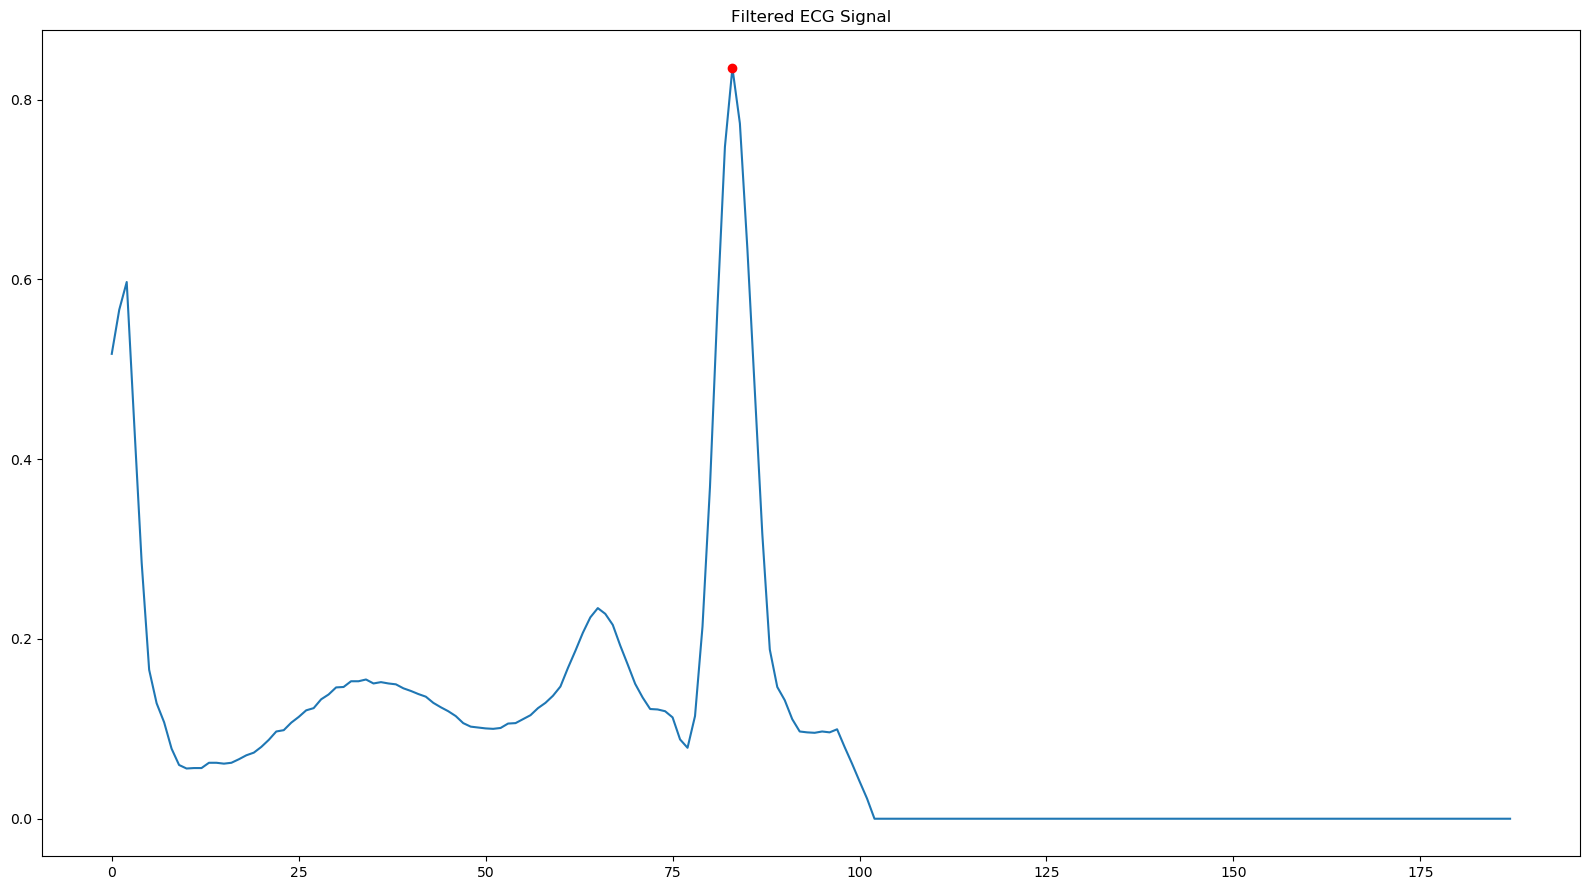

In [17]:
index, value = detect_r_peak(train_filtered[0][:180])
make_rpeak_plot(train_filtered[0], index)

### Analysis using R-Peak values

'N': Normal beat (class 0) <br>
'S': Supraventricular premature beat (class 1) <br>
'V': Premature ventricular contraction (class 2) <br>
'F': Fusion of ventricular and normal beat (class 3) <br>
'Q': Unclassifiable beat (class 4) <br>

Visualizing the ecg signals belonging to different classes

In [18]:
# replacing back the class column as its values were changed after filteration
train_filtered.T[187] = train_data[187]

### Normal Beats

In [19]:
normal = train_filtered.T[train_filtered.T[187]==0]
normal = normal.reset_index(drop=True)

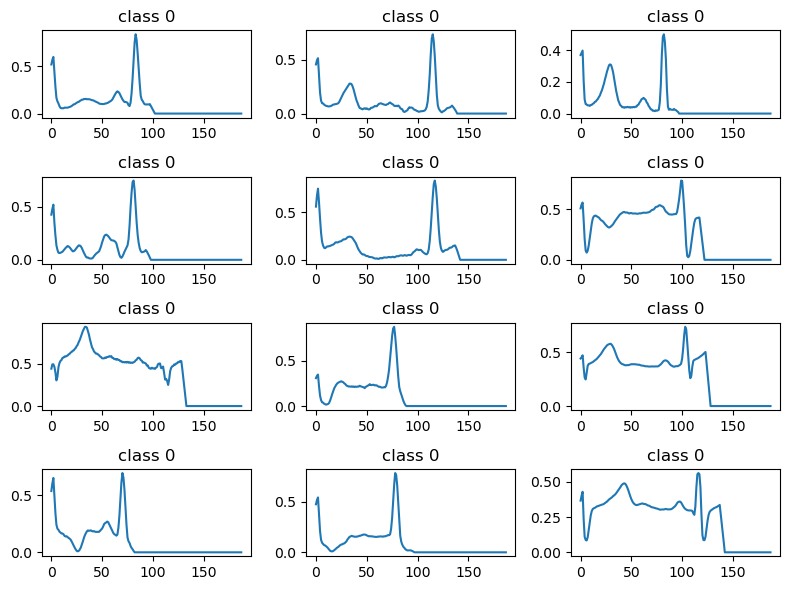

In [20]:
make_plot(normal, 'class 0', 11)

In [21]:
normal_index, normal_rpeak = detect_r_peak(normal)
normal_rpeak = normal_rpeak['peak_heights']
print(f"Mean R-Peak of Normal Beats: {sum(normal_rpeak)/len(normal_rpeak)}")

Mean R-Peak of Normal Beats: 0.7805916570594904


### Supraventricular premature beat

In [22]:
sp = train_filtered.T[train_filtered.T[187]==1]
sp = sp.reset_index(drop=True)

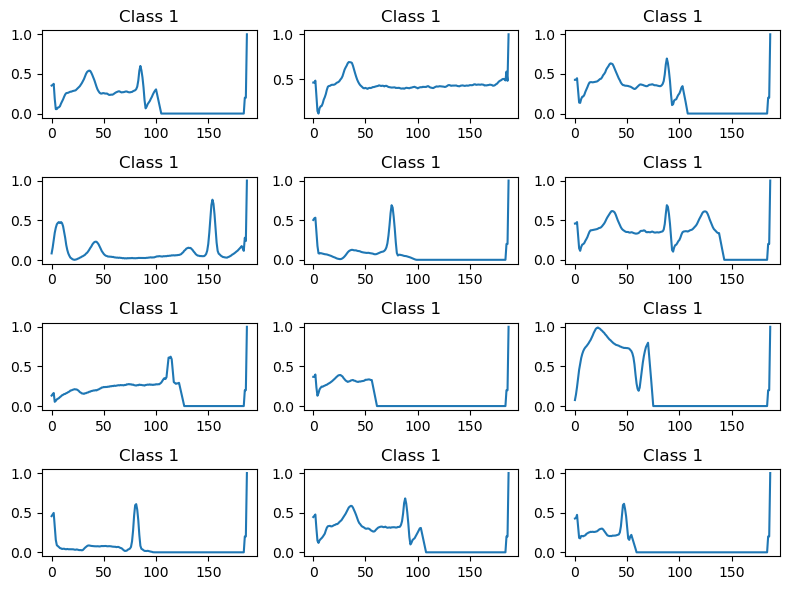

In [23]:
make_plot(sp, 'Class 1', 11)

In [24]:
sp_index, sp_rpeak = detect_r_peak(sp)
sp_rpeak = sp_rpeak['peak_heights']
print(f"Mean R-Peak of Supraventricular Premature Beats: {sum(sp_rpeak)/len(sp_rpeak)}")

Mean R-Peak of Supraventricular Premature Beats: 0.9697161862483392


### Premature ventricular contraction

In [25]:
pvc = train_filtered.T[train_filtered.T[187]==2]
pvc = pvc.reset_index(drop=True)

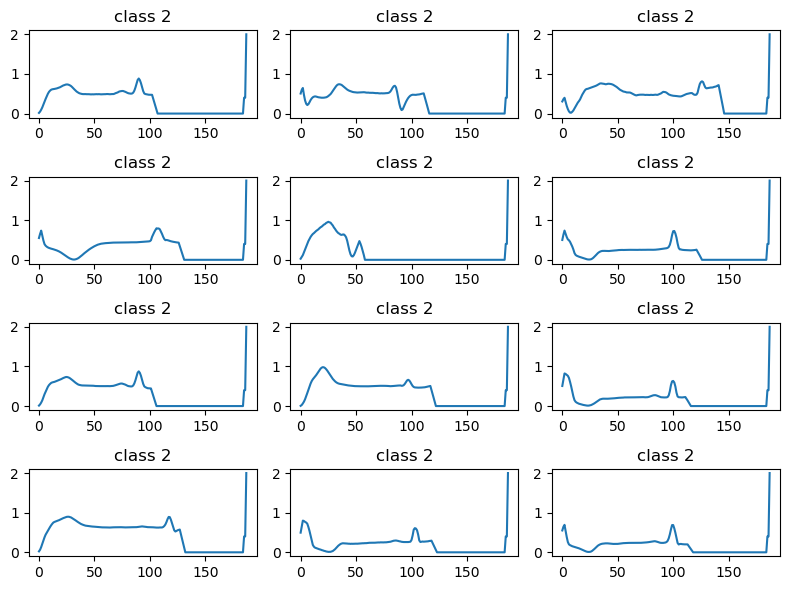

In [26]:
make_plot(pvc, 'class 2', 11)

In [27]:
pvc_index, pvc_rpeak = detect_r_peak(pvc)
pvc_rpeak = pvc_rpeak['peak_heights']
print(f"Mean R-Peak of Premature ventricular contraction Beats: {sum(pvc_rpeak)/len(pvc_rpeak)}")

Mean R-Peak of Premature ventricular contraction Beats: 1.8867150252986324


### Fusion of ventricular and normal beat

In [28]:
fv = train_filtered.T[train_filtered.T[187]==3]
fv = fv.reset_index(drop=True)

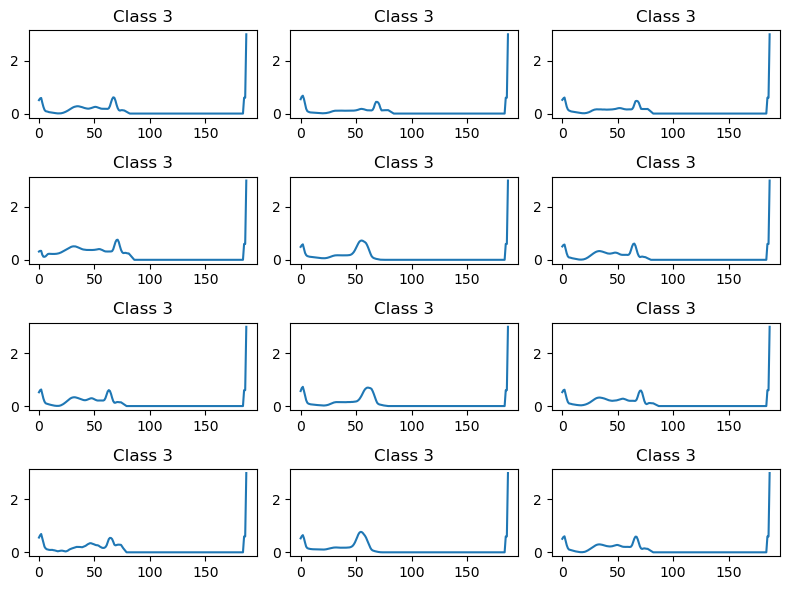

In [29]:
make_plot(fv, 'Class 3', 11)

In [30]:
fv_index, fv_rpeak = detect_r_peak(fv)
fv_rpeak = fv_rpeak['peak_heights']
print(f"Mean R-Peak of Fusion of ventricular and normal Beats: {sum(fv_rpeak)/len(fv_rpeak)}")

Mean R-Peak of Fusion of ventricular and normal Beats: 2.8262960545197804


### Unclassifiable beat

In [31]:
unclassifiable = train_filtered.T[train_filtered.T[187]==4]
unclassifiable = unclassifiable.reset_index(drop=True)

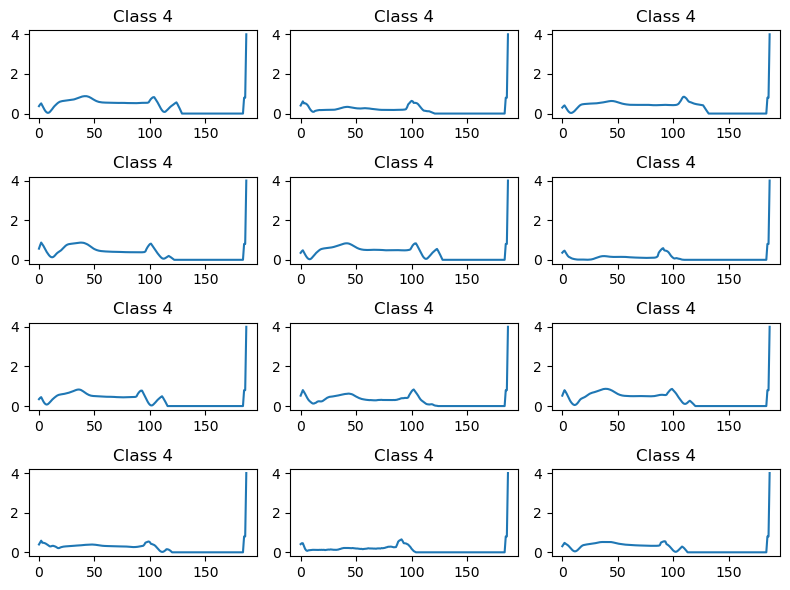

In [32]:
make_plot(unclassifiable, 'Class 4', 11)

In [33]:
unclassifiable_index, unclassifiable_rpeak = detect_r_peak(unclassifiable)
unclassifiable_rpeak = unclassifiable_rpeak['peak_heights']
print(f"Mean R-Peak of Fusion of ventricular and normal Beats: {sum(unclassifiable_rpeak)/len(unclassifiable_rpeak)}")

Mean R-Peak of Fusion of ventricular and normal Beats: 3.7589683235301665


# Deep Neural Networks

In [34]:
train_filtered.shape

(188, 87554)

In [35]:
test_filtered = pd.DataFrame()
for row in range(len(test_data)):
    test_filtered[row]  = preprocess(test_data.iloc[row,:])

In [36]:
test_filtered.T[187] = test_data[187]

In [37]:
X_train = train_filtered[:187]
X_train = X_train.T
y_train = train_filtered.T[187]

X_test = test_filtered[:187]
X_test = X_test.T
y_test = test_filtered.T[187]

In [38]:
train_data[187].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

In [39]:
clear_session()
model = keras.Sequential()
model.add(layers.Dense(64, input_shape=(X_train.shape[1],) ,activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                12032     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 14,277
Trainable params: 14,277
Non-trainable params: 0
_________________________________________________________________


In [40]:
from tensorflow.keras.callbacks import TensorBoard
import os

log_dir = "logs3"  # Provide a path for storing TensorBoard logs
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [41]:
model.fit(X_train, y_train, epochs=5, callbacks=[tensorboard_callback])
predictions = model.predict(X_test)

Epoch 1/5
87554/87554 [==============================] - 5s 61us/sample - loss: 0.0765
Epoch 2/5
87554/87554 [==============================] - 4s 49us/sample - loss: 0.0078
Epoch 3/5
87554/87554 [==============================] - 4s 48us/sample - loss: 0.0047
Epoch 4/5
87554/87554 [==============================] - 4s 43us/sample - loss: 0.0037
Epoch 5/5
87554/87554 [==============================] - 4s 43us/sample - loss: 0.0031


In [42]:
predicted_classes = np.argmax(predictions, axis=1)

In [43]:
score = accuracy_score(y_test, predicted_classes)
print("score: ", score)

score:  0.9993604969852


In [48]:
row = 2187
index = np.array(X_test.T[row])
index = index.reshape(1,-1)
predicted_class = model.predict(index)
predicted_class = np.argmax(predicted_class, axis=1)
print(f"predicted_class: {predicted_class} acutal class: {y_test[row]}") 

predicted_class: [0] acutal class: 0.0


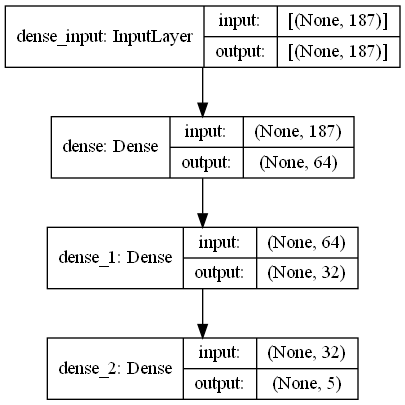

In [45]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)